In [1]:
def attention_head(n_tokens, dim, dim_head):
    macs = 0
    
    # token -> k, q, v
    macs += n_tokens * 3 * dim * dim_head
    
    # q * k'
    # (n_tokens, dim_head) * (dim_head, n_tokens) -> (n_tokens, n_tokens)
    macs += n_tokens * dim_head * n_tokens
    
    # Softmax e diviso sqrt(dim_head) 
    # ...
    
    # (q * k') * v
    # (n_tokens, n_tokens) * (n_tokens, dim_head) -> (n_tokens, dim_head)
    macs += n_tokens * n_tokens * dim_head
    
    return macs
    
def attention(n_tokens, dim, dim_head, n_heads):
    macs = 0
    
    macs += n_heads * attention_head(n_tokens, dim, dim_head)
    
    # Riporta gli z concatenati a dimensione dim
    macs += n_tokens * (dim_head * n_heads) * dim if not (n_heads == 1 and dim_head == dim) else 0
    
    return macs

def feed_forward(n_tokens, dim, mlp_dim):
    # 2 Linear: dim -> mlp_dim, mlp_dim -> dim
    return n_tokens * dim * mlp_dim * 2

def transformer(n_tokens, dim, dim_head, n_heads, mlp_dim, depth):
    return depth * (attention(n_tokens, dim, dim_head, n_heads) + feed_forward(n_tokens, dim, mlp_dim))

def vit(patch_size, dim, dim_head, n_heads, mlp_dim, depth):
    macs = 0
    
    n_tokens = 300 // patch_size
    
    # linear embedding
    macs += n_tokens * (14 * patch_size) * dim
    
    # +1 perché c'è cls_token
    macs += transformer(n_tokens + 1, dim, dim_head, n_heads, mlp_dim, depth)
    
    # output
    # Da mean o last token a class_scores
    macs += dim * 8
    
    return macs

import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)
               
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        qkv = qkv.chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0., use_cls_token=True):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        #self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.use_cls_token = use_cls_token
        if self.use_cls_token:
            self.pos_embedding = nn.Parameter(torch.empty(1, num_patches + 1, dim))
        else:
            self.pos_embedding = nn.Parameter(torch.empty(1, num_patches, dim))
        #nn.init.kaiming_uniform_(self.pos_embedding, a=5 ** .5)
        nn.init.normal_(self.pos_embedding, std=.02)

        #self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.cls_token = nn.Parameter(torch.empty(1, 1, dim))
        nn.init.zeros_(self.cls_token)
        
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        # MACs: patch_size * n_patches * dim, es (30 * 14) * 10 * 300
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        
        if self.use_cls_token:
            cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
            x = torch.cat((cls_tokens, x), dim=1)
            x += self.pos_embedding[:, :(n + 1)]
        else :
            x += self.pos_embedding
        
        x = self.dropout(x)
        
        # FeedForward    Attention       project out
        # 300*300*10*2 + 300*(64*3)*10 + ((64)*300*10)
        # Attention -> manca softmax e attention vera e propria, c'è solo linear encoding a qkv
        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        
        x = self.to_latent(x)
        x = self.mlp_head(x)
        return x
    
# Ratio of params
def vit_aff_ratio(patch_size, dim, dim_head, n_heads, mlp_dim, depth): 
    n_tokens = 300 // patch_size + 1
    
    a = (((dim) * dim_head * 3 * n_heads) + ((dim_head * n_heads) * dim) + dim)
    ff = dim * mlp_dim * 2 + mlp_dim + dim
    
    return a / (a + ff)

In [ ]:
transformer(n_tokens=31, dim, dim_head, n_heads, mlp_dim, depth)

In [24]:
ln = nn.LayerNorm(64)
[p.nelement() for p in ln.parameters()]

c:\users\francesco\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


[64, 64]

In [27]:
ln.state_dict()

c:\users\francesco\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


OrderedDict([('weight',
              tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])),
             ('bias',
              tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))])

In [2]:
v = ViT(image_size=(1, 300), patch_size=(1, 10), num_classes=8, dim=64, depth=1, heads=8, mlp_dim=128, pool = 'cls', channels = 14, dim_head = 32, dropout = 0., emb_dropout = 0., use_cls_token=True)

In [3]:
sum([param.nelement() for param in v.parameters()])

94152

In [4]:
def get_results(configs, results_, additional_columns, extract_model_hparams):
        
    acccs = []
    acccs_steady = []
    acccs_val0 = []
    acccs_steady_val0 = []
    acccs_val1 = []
    acccs_steady_val1 = []

    acccs_val_val0 = 0
    acccs_val_val1 = 0
    acccs_train_val0 = 0
    acccs_train_val1 = 0
    
    acccs_steady_persubject = np.array([0] * 10, dtype=float)
    preds_steady_bincounts_subject = np.zeros((10, 8), dtype=int)
    
    for config, r in zip(configs, results_):

        accs = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds'], r['val-fold_0']['y_trues'])):
            accs[i] += (y_pred == y_true).sum().float() / len(y_true)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds'], r['val-fold_1']['y_trues'])):
            accs[i] += (y_pred == y_true).sum().float() / len(y_true)
        accs /= 2

        accs_steady = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds_steady'], r['val-fold_0']['y_trues_steady'])):
            accs_steady[i] += (y_pred == y_true).sum().float() / len(y_true)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds_steady'], r['val-fold_1']['y_trues_steady'])):
            accs_steady[i] += (y_pred == y_true).sum().float() / len(y_true)
        accs_steady /= 2

        accs_val0 = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds'], r['val-fold_0']['y_trues'])):
            accs_val0[i] += (y_pred == y_true).sum().float() / len(y_true)

        accs_steady_val0 = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds_steady'], r['val-fold_0']['y_trues_steady'])):
            accs_steady_val0[i] += (y_pred == y_true).sum().float() / len(y_true)
            acccs_steady_persubject[r['subject'] - 1] += (y_pred == y_true).sum().float() / len(y_true)
            preds_steady_bincounts_subject[r['subject'] - 1] += y_pred.bincount(minlength=(y_true.max() + 1)).numpy()
            
        accs_val1 = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds'], r['val-fold_1']['y_trues'])):
            accs_val1[i] += (y_pred == y_true).sum().float() / len(y_true)

        accs_steady_val1 = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds_steady'], r['val-fold_1']['y_trues_steady'])):
            accs_steady_val1[i] += (y_pred == y_true).sum().float() / len(y_true)
            acccs_steady_persubject[r['subject'] - 1] += (y_pred == y_true).sum().float() / len(y_true)
            preds_steady_bincounts_subject[r['subject'] - 1] += y_pred.bincount(minlength=(y_true.max() + 1)).numpy()
            
        acccs_train_val0 += r['val-fold_0']['losses_accs'][-1]['train_acc']
        acccs_train_val1 += r['val-fold_1']['losses_accs'][-1]['train_acc']

        acccs_val_val0 += r['val-fold_0']['losses_accs'][-1]['val_acc']
        acccs_val_val1 += r['val-fold_1']['losses_accs'][-1]['val_acc']

        acccs.append(accs)
        acccs_steady.append(accs_steady)
        acccs_val0.append(accs_val0)
        acccs_steady_val0.append(accs_steady_val0)
        acccs_val1.append(accs_val1)
        acccs_steady_val1.append(accs_steady_val1)
        
    test_sessions = len(r['test_sessions'])

    acccs_steady_persubject /= test_sessions * 2 # 5 sessioni per due

    acccs = np.array(acccs).mean(axis=0)

    acccs_steady_ = np.array(acccs_steady).mean(axis=1)
    acccs_steady = np.array(acccs_steady).mean(axis=0)

    acccs_val0 = np.array(acccs_val0).mean(axis=0)
    acccs_val1 = np.array(acccs_val1).mean(axis=0)
    acccs_steady_val0 = np.array(acccs_steady_val0).mean(axis=0)
    acccs_steady_val1 = np.array(acccs_steady_val1).mean(axis=0)
    acccs_val_val0 /= 10
    acccs_val_val1 /= 10
    acccs_train_val0 /= 10
    acccs_train_val1 /= 10
    
    model_hparams = extract_model_hparams(config)

    return {        
        **model_hparams,

        **additional_columns,

        "train accuracy steady fold1":  acccs_train_val0,
        "train accuracy steady fold2":  acccs_train_val1,
        "train accuracy steady avg2folds": .5 * (acccs_train_val0 + acccs_train_val1),

        "validation accuracy steady fold1": acccs_val_val0,
        "validation accuracy steady fold2": acccs_val_val1,

        "test accuracy fold1": acccs_val0.mean(),
        "test accuracy fold2": acccs_val1.mean(),
        "test accuracy avg2folds": acccs.mean(), 
        "test accuracy steady fold1": acccs_steady_val0.mean(),
        "test accuracy steady fold2": acccs_steady_val1.mean(), 
        "test accuracy steady avg2folds": acccs_steady.mean(),

        "test accuracy steady avg2folds std across sessions": acccs_steady.std(),
        "test accuracy steady avg2folds std across subjects": acccs_steady_.std(),
        
        **{
          f"test accuracy steady session{s + 1 + test_sessions} avg2folds": acccs_steady[s] for s in range(test_sessions)
        },
        
        **{
            f"test accuracy steady subj{s} avg2folds": acccs_steady_persubject[s] for s in range(10)
        },
        
        **{
            f"test preds steady subj{s} avg2folds": preds_steady_bincounts_subject[s] for s in range(10)
        },
    }

from pickle import load

import numpy as np
import pandas as pd

def group_configs(configs, group_exclude_columns):
    # https://stackoverflow.com/a/6027615
    import collections.abc

    def flatten(d, parent_key='', sep='_'):
        items = []
        for k, v in d.items():
            new_key = parent_key + sep + k if parent_key else k
            if isinstance(v, collections.abc.MutableMapping):
                items.extend(flatten(v, new_key, sep=sep).items())
            else:
                items.append((new_key, v))
        return dict(items)

    df = pd.DataFrame([flatten(config) for config in configs])
    df['row_id'] = [[a] for a in df.index]
    
    if 'training_config_lr_scheduler_hparams_milestones' in df:
        df['training_config_lr_scheduler_hparams_milestones'] = df['training_config_lr_scheduler_hparams_milestones'].apply(lambda x: ','.join(map(str, x)))
    df = df.fillna('null')
    
    grouped_configs = df.groupby([c for c in df.columns if c not in group_exclude_columns]).agg({'subjects': 'count', 'row_id': 'sum'})
    
    if (grouped_configs['subjects'] != 10).sum() != 0:
        display(grouped_configs)
        raise ValueError("For every config, it is assumed that you trained on 10 subjects")
    
    return list(grouped_configs["row_id"])


extract_model_hparams_generator = {
    'vit': lambda config: {
        "window_size": config["image_size"][1],
        "patch_size": config["patch_size"][1],
        "dim_projection": config["dim"],
        "dim_ff": config["mlp_dim"],
        "dim_head": config["dim_head"],
        "n_heads": config["heads"],
        "depth": config["depth"],
        "dropout": config["dropout"],
        "emb_dropout": config["emb_dropout"],
        
        "MACs": vit(patch_size=config["patch_size"][1], dim=config["dim"], dim_head=config["dim_head"], n_heads=config["heads"], mlp_dim=config["mlp_dim"], depth=config["depth"]),
        "params":  sum([param.nelement() for param in ViT(channels=14, image_size=(1, 300), patch_size=config["patch_size"], dim=config["dim"], dim_head=config["dim_head"], heads=config["heads"], mlp_dim=config["mlp_dim"], depth=config["depth"], num_classes=8).parameters()]),
        "params_aff_ratio": vit_aff_ratio(patch_size=config["patch_size"][1], dim=config["dim"], dim_head=config["dim_head"], n_heads=config["heads"], mlp_dim=config["mlp_dim"], depth=config["depth"]),
        
    },
    'temponet': lambda _: {
        "MACs": 16028672,
        "params": 461512,
    },
}

def read_results(filename, additional_columns=None, group_exclude_columns=None, model_name='vit'):
    additional_columns = {} if additional_columns is None else additional_columns
    
    group_exclude_columns = set() if group_exclude_columns is None else group_exclude_columns
    group_exclude_columns = group_exclude_columns.union({'subjects', 'row_id'})
    
    configs, results_ = load(open(filename, 'rb'))
    
    groups_indices = group_configs(configs, group_exclude_columns)
    
    df_l = []
    for idx in groups_indices:
        c = [configs[i] for i in idx]
        r = [results_[i] for i in idx]
        
        df_l.append(get_results(c, r, additional_columns, extract_model_hparams_generator[model_name]))   
    
    return pd.DataFrame(df_l) 

def get_rows(all_res_vit, group):
    m = None
    for k in group.keys():
        current_m = all_res_vit[k] == group[k]
        if m is None:
            m = current_m
        else:
            m &= current_m
    return all_res_vit[m].copy()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
vit_pretrain_9 = read_results("exp9/grid_5sess10subj_nopretraining_fold2/results_1627417222.pickle", {"pretraining": 'no', "pretraining_epochs": 0, "finetune_epochs": 200}, group_exclude_columns={'pretrained'}) \
        .append(read_results("exp9/grid_5sess10subj_pretraining/finetune_100/results_1626421922.pickle", {"pretraining": 'all_others_20', "pretraining_epochs": 100, "finetune_epochs": 20}, group_exclude_columns={'pretrained'}), ignore_index=True) \
        .append(read_results("exp9/grid_5sess10subj_pretraining/finetune_100_fix/results_1627588086.pickle", {"pretraining": 'all_others_20_fix', "pretraining_epochs": 100, "finetune_epochs": 40}, group_exclude_columns={'pretrained'}), ignore_index=True) \
        .append(read_results("exp9/grid_5sess10subj_pretraining/finetune_100_fix_10/results_1627593378.pickle", {"pretraining": 'all_others_20_fix_10', "pretraining_epochs": 100, "finetune_epochs": 40}, group_exclude_columns={'pretrained'}), ignore_index=True) \
.append(read_results("exp9/grid_5sess10subj_pretraining/finetune_100_fix_10bs8/results_1627593378.pickle", {"pretraining": 'all_others_20_fix_10bs8', "pretraining_epochs": 100, "finetune_epochs": 40}, group_exclude_columns={'pretrained'}), ignore_index=True) \
.append(read_results("exp9/pretrain9.5/results_1627617535.pickle", {"pretraining": 'all_others_9.5', "pretraining_epochs": 100, "finetune_epochs": 20}, group_exclude_columns={'pretrained'}), ignore_index=True) \
        .append(read_results("exp9/vit_pretraining_9/results_1627311468.pickle", {"pretraining": 'all_others_min20-20', "pretraining_epochs": 100, "finetune_epochs": "min20-20"}, group_exclude_columns={'pretrained'}), ignore_index=True) \
        .append(read_results("exp9/vit_pretraining_9/results_1627333294.pickle", {"pretraining": 'all_others_min20-20from40', "pretraining_epochs": 40, "finetune_epochs": "min20-20"}, group_exclude_columns={'pretrained'}), ignore_index=True) \
        .append(read_results("exp9/vit_pretraining_9/results_1627341881.pickle", {"pretraining": 'all_others_hd', "pretraining_epochs": 100, "finetune_epochs": "min20-20"}, group_exclude_columns={'pretrained'}), ignore_index=True)

In [6]:
vit_pretrain_9

,window_size,patch_size,dim_projection,dim_ff,dim_head,n_heads,depth,dropout,emb_dropout,MACs,params,params_aff_ratio,pretraining,pretraining_epochs,finetune_epochs,train accuracy steady fold1,train accuracy steady fold2,train accuracy steady avg2folds,validation accuracy steady fold1,validation accuracy steady fold2,test accuracy fold1,test accuracy fold2,test accuracy avg2folds,test accuracy steady fold1,test accuracy steady fold2,test accuracy steady avg2folds,test accuracy steady avg2folds std across sessions,test accuracy steady avg2folds std across subjects,test accuracy steady session6 avg2folds,test accuracy steady session7 avg2folds,test accuracy steady session8 avg2folds,test accuracy steady session9 avg2folds,test accuracy steady session10 avg2folds,test accuracy steady subj0 avg2folds,test accuracy steady subj1 avg2folds,test accuracy steady subj2 avg2folds,test accuracy steady subj3 avg2folds,test accuracy steady subj4 avg2folds,test accuracy steady subj5 avg2folds,test accuracy steady subj6 avg2folds,test accuracy steady subj7 avg2folds,test accuracy steady subj8 avg2folds,test accuracy steady subj9 avg2folds,test preds steady subj0 avg2folds,test preds steady subj1 avg2folds,test preds steady subj2 avg2folds,test preds steady subj3 avg2folds,test preds steady subj4 avg2folds,test preds steady subj5 avg2folds,test preds steady subj6 avg2folds,test preds steady subj7 avg2folds,test preds steady subj8 avg2folds,test preds steady subj9 avg2folds
0,300,10,64,128,32,8,1,0.2,0,3300864,94152,0.798287,no,0,200,0.974234,0.969996,0.972115,0.691544,0.691096,0.481805,0.477129,0.479467,0.639890,0.628881,0.634386,0.017992,0.079836,0.637813,0.626278,0.665994,0.630395,0.611449,0.741879,0.675315,0.616850,0.667227,0.784742,0.636111,0.575114,0.555989,0.523119,0.567511,"[43683, 8300, 7663, 10186, 4802, 8483, 8844, 5...","[37096, 7620, 4609, 6389, 15561, 10865, 8635, ...","[52591, 5152, 9735, 4958, 7867, 6127, 5779, 5193]","[45926, 7769, 5405, 7001, 6477, 10985, 6543, 6...","[52599, 8356, 7453, 7592, 4948, 4856, 7237, 4289]","[44874, 5145, 4933, 5653, 6904, 13364, 10596, ...","[39292, 8151, 9642, 4945, 11295, 7753, 11643, ...","[61414, 10642, 5421, 6018, 4191, 1553, 5291, 3...","[74741, 5096, 6328, 2890, 3584, 1901, 3079, 1449]","[43748, 4575, 11866, 8372, 9800, 8609, 4053, 6..."
1,300,10,64,128,32,8,1,0.2,0,3300864,94152,0.798287,all_others_20,100,20,0.792333,0.737745,0.765039,0.655784,0.660054,0.460341,0.444448,0.452395,0.608122,0.593420,0.600771,0.015431,0.120493,0.605976,0.599211,0.625779,0.578535,0.594354,0.755758,0.392205,0.477707,0.692919,0.783042,0.472039,0.645453,0.617244,0.558191,0.613153,"[42382, 9906, 7322, 8294, 4515, 10634, 9355, 4...","[97068, 0, 0, 0, 0, 0, 0, 0]","[83428, 5730, 3614, 1221, 636, 2398, 7, 368]","[44084, 7843, 7732, 6714, 4990, 11060, 7849, 6...","[52022, 9207, 7626, 8803, 4678, 5942, 4941, 4111]","[51263, 2941, 8735, 2120, 4437, 8606, 16523, 2...","[37519, 8339, 11970, 9627, 7565, 7951, 9157, 5...","[53888, 7964, 6869, 5838, 5333, 1970, 7512, 8568]","[73465, 6928, 3997, 3855, 3498, 2091, 3130, 2104]","[40454, 4862, 6168, 8926, 15658, 10874, 5963, ..."
2,300,10,64,128,32,8,1,0.2,0,3300864,94152,0.798287,all_others_20_fix,100,40,0.955310,0.942484,0.948897,0.708360,0.714751,0.499362,0.488291,0.493827,0.658357,0.643371,0.650864,0.015441,0.077375,0.657441,0.649427,0.675946,0.630234,0.641269,0.753193,0.656614,0.642311,0.678129,0.806790,0.618921,0.641813,0.594206,0.520928,0.595732,"[42537, 9700, 7024, 8530, 5099, 11005, 8204, 5...","[35400, 7959, 2862, 4531, 15576, 10961, 9577, ...","[50162, 4469, 9065, 5241, 6647, 9932, 7253, 4633]","[46081, 8482, 5517, 6489, 6605, 10703, 7144, 5...","[52839, 7440, 7690, 8170, 4698, 6871, 5663, 3959]","[42317, 5905, 5788, 6042, 4677, 15283, 11544, ...","[37716, 8323, 10726, 10230, 7541, 8194, 10243,...","[56188, 8111, 6442, 4636, 6892, 2265, 8314, 5094]","[67523, 9115, 5183, 2529, 3712, 4363, 3772, 2871]","[44283, 3920, 4881, 6871, 14326, 12657, 5057, ..."
3,300,10,64,128,32

In [7]:
vit_pretrain_9b = read_results("exp9/pretrain9.5b/results_1631301862.pickle", {"pretraining": 'all_others_9.5', "pretraining_epochs": 100, "finetune_epochs": 20}, group_exclude_columns={'pretrained'})
vit_pretrain_9c = read_results("exp9/pretrain9.5c/results_1631304147.pickle", {"pretraining": 'all_others_9.5', "pretraining_epochs": 100, "finetune_epochs": 20}, group_exclude_columns={'pretrained'})

In [8]:
vit_pretrain_9c

,window_size,patch_size,dim_projection,dim_ff,dim_head,n_heads,depth,dropout,emb_dropout,MACs,params,params_aff_ratio,pretraining,pretraining_epochs,finetune_epochs,train accuracy steady fold1,train accuracy steady fold2,train accuracy steady avg2folds,validation accuracy steady fold1,validation accuracy steady fold2,test accuracy fold1,test accuracy fold2,test accuracy avg2folds,test accuracy steady fold1,test accuracy steady fold2,test accuracy steady avg2folds,test accuracy steady avg2folds std across sessions,test accuracy steady avg2folds std across subjects,test accuracy steady session6 avg2folds,test accuracy steady session7 avg2folds,test accuracy steady session8 avg2folds,test accuracy steady session9 avg2folds,test accuracy steady session10 avg2folds,test accuracy steady subj0 avg2folds,test accuracy steady subj1 avg2folds,test accuracy steady subj2 avg2folds,test accuracy steady subj3 avg2folds,test accuracy steady subj4 avg2folds,test accuracy steady subj5 avg2folds,test accuracy steady subj6 avg2folds,test accuracy steady subj7 avg2folds,test accuracy steady subj8 avg2folds,test accuracy steady subj9 avg2folds,test preds steady subj0 avg2folds,test preds steady subj1 avg2folds,test preds steady subj2 avg2folds,test preds steady subj3 avg2folds,test preds steady subj4 avg2folds,test preds steady subj5 avg2folds,test preds steady subj6 avg2folds,test preds steady subj7 avg2folds,test preds steady subj8 avg2folds,test preds steady subj9 avg2folds
0,300,10,64,128,32,8,1,0.2,0,3300864,94152,0.798287,all_others_9.5,100,20,0.932065,0.915645,0.923855,0.708056,0.716389,0.506473,0.494441,0.500457,0.667252,0.647776,0.657514,0.016977,0.074592,0.665426,0.657406,0.684969,0.641145,0.638624,0.75909,0.674447,0.646438,0.674821,0.81366,0.600882,0.641972,0.606031,0.549132,0.608667,"[42153, 9970, 7913, 7835, 4195, 10777, 9506, 4...","[36102, 8318, 3140, 4270, 14219, 10954, 8795, ...","[51602, 4234, 7483, 5509, 7375, 10686, 6052, 4...","[45401, 8771, 6631, 6750, 5203, 11136, 7484, 5...","[52869, 7504, 8083, 8359, 4142, 6619, 4987, 4767]","[41944, 5556, 7338, 6061, 5230, 14235, 11043, ...","[37456, 8539, 11193, 9798, 7646, 8642, 9696, 4...","[54723, 8444, 6060, 5018, 5919, 2229, 9256, 6293]","[73116, 5893, 4508, 3185, 3948, 3068, 3261, 2089]","[42202, 4899, 4911, 7442, 16119, 11169, 5074, ..."


In [9]:
all_res_vit = \
    read_results("exp5/grid_5sess10subj/finetuneFrom100/results_1623845783.pickle", {"pretraining": "fold1", "pretraining_dropout": .2, "pretraining_epochs": 100, "finetune_epochs": 20})\
    .append(read_results("exp6/grid_5sess10subj_dim64_p10/finetune_100/results_1624706075.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp6/grid_5sess10subj_dim64_p30/finetune_100/results_1624804897.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp8/grid_5sess10subj_patches/finetune_100/results_1626031724.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp9/grid_5sess10subj_patches/finetune_100/results_1626498530.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .fillna(value={"pretraining": "fold1", "pretraining_dropout": .2, })

In [10]:
res_ = get_rows(all_res_vit, 
               {'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 8, 'depth': 1,
                'pretraining_dropout': .2, 'pretraining_epochs': 100, 'pretraining': 'fold1'}) \
        .append(get_rows(all_res_vit, 
               {'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 2, 'depth': 2,
                'pretraining_dropout': .2, 'pretraining_epochs': 100, 'pretraining': 'fold1'}))

res_vit_pretrain = res_.sort_values(by=['n_heads', 'patch_size'])

loc = res_vit_pretrain[(res_vit_pretrain['patch_size'] == 10) & (res_vit_pretrain['n_heads'] == 8)].index[0]
res_vit_pretrain.loc[loc] = get_rows(vit_pretrain_9,  {'pretraining': 'all_others_9.5', 'patch_size': 10, 'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 8, 'depth': 1}).iloc[0]

In [11]:
all_res_tcn = read_results("exp7/tcn_pretrain/results_1625075271.pickle", {"pretraining": 'fold1'}, model_name='temponet') \
.append(read_results("exp7/tcn_pretrain/results_1625166399.pickle", {"pretraining": 'no'}, model_name='temponet'), ignore_index=True) \
.append(read_results("exp7/tcn_pretrain/results_1626361771.pickle", {"pretraining": 'fold2'}, model_name='temponet'), ignore_index=True)

In [12]:
res_ = get_rows(all_res_tcn, 
               {'pretraining': 'fold1'}) \
        .append(get_rows(all_res_tcn, 
               {'pretraining': 'no'}))

res_tcn = res_

In [13]:
all_res_vit_2 = \
    read_results("exp10/no_pretraining_/results_1630304612.pickle", {"pretraining": False}) \
    .append(read_results("exp10/no_pretraining_/results_1630304773.pickle", {"pretraining": False}), ignore_index=True) \

In [14]:
res_untrained = get_rows(all_res_vit_2, 
               {'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 8, 'depth': 1,
                'pretraining': False}) \
        .append(get_rows(all_res_vit_2, 
               {'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 2, 'depth': 2,
                'pretraining': False}))

res_vit_nopretrain = res_untrained.sort_values(by=['n_heads', 'patch_size']).copy()

In [15]:
#writer = pd.ExcelWriter('results_.xlsx', engine='xlsxwriter')
from styleframe import StyleFrame, Styler
writer = StyleFrame.ExcelWriter('results_complete.xlsx')

def write_excel(df, name):
    sf = StyleFrame(df, Styler(border_type=None, fill_pattern_type=None))
    sf.to_excel(writer, sheet_name=name, best_fit=list(df.columns))

write_excel(res_vit_nopretrain, 'ViT NoPretraining')
write_excel(res_vit_pretrain, 'ViT Pretraining')
write_excel(res_tcn, 'TEMPONET')

writer.save()

In [16]:
from styleframe import StyleFrame, Styler
writer = StyleFrame.ExcelWriter('results_mini.xlsx')

cols = ['validation accuracy steady fold1'] + ['test accuracy steady avg2folds'] + [f'test accuracy steady session{s} avg2folds' for s in [6, 7, 8, 9, 10]]

res_vit_nopretrain['model'] = 'ViT'
res_vit_pretrain['model'] = 'ViT'
res_tcn['model'] = 'TEMPONet'

res_mac_params = res_vit_nopretrain[['model', 'patch_size', 'n_heads', 'MACs', 'params']].append(res_tcn[['model', 'MACs', 'params']].head(1))

res_vit_pretrain_mini = res_vit_pretrain[['model', 'pretraining', 'patch_size', 'n_heads'] + cols].rename(columns={'validation accuracy steady fold1': 'validation accuracy steady'})
res_vit_pretrain_mini['pretraining'] = True
res_vit_nopretrain_mini = res_vit_nopretrain[['model', 'pretraining', 'patch_size', 'n_heads'] + cols].rename(columns={'validation accuracy steady fold1': 'validation accuracy steady'})
res_tcn_mini = res_tcn[['model', 'pretraining'] + cols].copy().rename(columns={'validation accuracy steady fold1': 'validation accuracy steady'})
res_tcn_mini['pretraining'] = res_tcn_mini['pretraining'].str.replace('fold1', 'True')

res_accs = res_vit_nopretrain_mini.append(res_vit_pretrain_mini).append(res_tcn_mini)
res_accs.to_csv('a.csv', index=False)
res_accs = pd.read_csv('a.csv')
write_excel(res_accs, 'Accuracies')

res_mac_params.to_csv('a.csv', index=False)
res_mac_params = pd.read_csv('a.csv')
write_excel(res_mac_params, 'MACsParams')

writer.save()

c:\users\francesco\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


c:\users\francesco\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


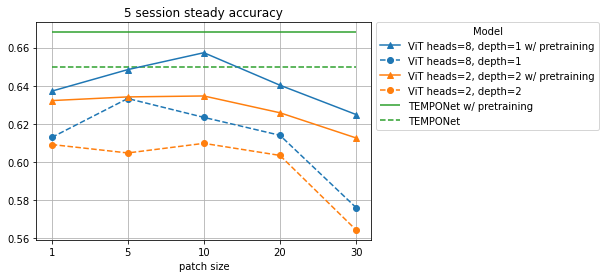

In [17]:
res_ = res_vit_pretrain.copy()
res_untrained = res_vit_nopretrain.copy()
tcn = all_res_tcn.loc[all_res_tcn[all_res_tcn['pretraining'] == 'fold1'].index[0]]
tcn_macs, tcn_params, tcn_test_accuracy_steady_avg2folds = tcn['MACs'], tcn['params'], tcn['test accuracy steady avg2folds']
tcn_nop = all_res_tcn.loc[all_res_tcn[all_res_tcn['pretraining'] == 'no'].index[0]]
tcn_macs, tcn_params, tcn_test_accuracy_steady_avg2folds_nop = tcn['MACs'], tcn['params'], tcn_nop['test accuracy steady avg2folds']

import matplotlib.pyplot as plt

for i, depth in enumerate([1, 2]):
    r = res_[res_['depth'] == depth]
    plt.plot([str(x) for x in r['patch_size']], list(r['test accuracy steady avg2folds']), marker='^', label=f"ViT heads={8 if depth == 1 else 2}, depth={depth} w/ pretraining", color=f"C{i}", linestyle='-')
    r = res_untrained[res_untrained['depth'] == depth]
    plt.plot([str(x) for x in r['patch_size']], list(r['test accuracy steady avg2folds']), marker='o', label=f"ViT heads={8 if depth == 1 else 2}, depth={depth}", color=f"C{i}", linestyle='--')

plt.hlines(tcn_test_accuracy_steady_avg2folds, 0, 4, color='C2', label='TEMPONet w/ pretraining')
plt.hlines(tcn_test_accuracy_steady_avg2folds_nop, 0, 4, linestyle='--', color='C2', label='TEMPONet')

plt.grid('on')
plt.xlabel('patch size')
#plt.suptitle('ViT 2 head')
plt.title('5 session steady accuracy')
#plt.legend(title="depth", loc="upper right", bbox_to_anchor=(1.3, 1.02))
plt.legend(title="Model", loc="upper left", bbox_to_anchor=(1, 1.025))
plt.show()

In [18]:
pretraining = get_rows(vit_pretrain_9,  {'pretraining': 'all_others_9.5', 'patch_size': 10, 'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 8, 'depth': 1})
pretraining_subjects = np.array(pretraining[[f'test accuracy steady subj{s} avg2folds' for s in range(10)]].iloc[0])
nopretraining = get_rows(vit_pretrain_9,  {'pretraining': 'no', 'patch_size': 10, 'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 8, 'depth': 1})
nopretraining_subjects = np.array(nopretraining[[f'test accuracy steady subj{s} avg2folds' for s in range(10)]].iloc[0])

fig1 = pd.DataFrame({'subject': np.arange(1, 11) ,'accuracy': nopretraining_subjects, 'accuracy pretraining': pretraining_subjects})
fig2 = res_accs[['model', 'pretraining', 'patch_size', 'n_heads', 'test accuracy steady avg2folds']]
fig3 = res_mac_params
fig4 = res_accs[(res_accs['model'] == 'ViT') & (res_accs['patch_size'] == 10) | (res_accs['model'] == 'TEMPONet')]

c:\users\francesco\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [19]:
from styleframe import StyleFrame, Styler
writer = StyleFrame.ExcelWriter('results2.xlsx')

write_excel(fig1, 'Pretraining Subjects')
write_excel(fig2, 'Patch dim Acc')
write_excel(fig3, 'MACs Params')
write_excel(fig4, 'Testing sessions')

writer.save()

c:\users\francesco\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [20]:
# fix wrong pretrain
pretraining = get_rows(res_vit_pretrain,  {'patch_size': 10, 'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 8, 'depth': 1})
pretraining_subjects = np.array(pretraining[[f'test accuracy steady subj{s} avg2folds' for s in range(10)]].iloc[0])
nopretraining = get_rows(res_vit_nopretrain,  {'patch_size': 10, 'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 8, 'depth': 1})
nopretraining_subjects = np.array(nopretraining[[f'test accuracy steady subj{s} avg2folds' for s in range(10)]].iloc[0])

fig1 = pd.DataFrame({'subject': np.arange(1, 11) ,'accuracy': nopretraining_subjects, 'accuracy pretraining': pretraining_subjects})
fig2 = res_accs[['model', 'pretraining', 'patch_size', 'n_heads', 'test accuracy steady avg2folds']]
fig3 = res_mac_params
fig4 = res_accs[(res_accs['model'] == 'ViT') & (res_accs['patch_size'] == 10) | (res_accs['model'] == 'TEMPONet')]

from styleframe import StyleFrame, Styler
writer = StyleFrame.ExcelWriter('results2.xlsx')

write_excel(fig1, 'Pretraining Subjects')
write_excel(fig2, 'Patch dim Acc')
write_excel(fig3, 'MACs Params')
write_excel(fig4, 'Testing sessions')

writer.save()

c:\users\francesco\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [21]:
accs = read_results("exp10/check_pretrain9.5/results_1631106374.pickle", group_exclude_columns={'pretrained'})
accs.iloc[0].to_excel('aa.xlsx')

c:\users\francesco\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
